In [37]:
# import required libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from keras import models;
from keras import layers;
from keras import optimizers;
sns.set()

### Business understanding
##### 1. In this work, we try to understand the features that influence sptify songs popularity.
##### 2. Based on 1, to build a ML model for predicting popularity of a track

In [4]:
# source of the data: available here: https://www.kaggle.com/ektanegi/spotifydata-19212020
# load data
data = pd.read_csv("data/data.csv")
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


### Data Understanding and Preparation

In [6]:
data.shape

(169909, 19)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

#### we can get the description of the dataset columns from spotify web API documentation 
##### link: (https://developer.spotify.com/documentation/web-api/reference/#/operations/get-track)
#####  Some of the descriptions are:
##### acousticness
number
<float>
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

##### danceability
number
<float>
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

##### duration_ms
integer
The duration of the track in milliseconds.

##### energy
number
<float>
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

##### instrumentalness
number
<float>
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

##### key
integer
The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
>= -1
<= 11

##### liveness
number
<float>
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

##### loudness
number
<float>
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

##### mode
integer
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

##### speechiness
number
<float>
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

##### tempo
number
<float>
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

##### valence
number
<float>
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

##### popularity

The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently.

In [8]:
# check null columns
data.isnull().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

In [9]:
## get basic descriptive statistics for columns
data.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,169909.000000,169909.000000,1.699090e+05,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000
mean,0.493214,0.538150,2.314062e+05,0.488593,0.084863,0.161937,5.200519,0.206690,-11.370289,0.708556,31.556610,0.094058,116.948017,0.532095,1977.223231
std,0.376627,0.175346,1.213219e+05,0.267390,0.278679,0.309329,3.515257,0.176796,5.666765,0.454429,21.582614,0.149937,30.726937,0.262408,25.593168
min,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1921.000000
25%,0.094500,0.417000,1.710400e+05,0.263000,0.000000,0.000000,2.000000,0.098400,-14.470000,0.000000,12.000000,0.034900,93.516000,0.322000,1957.000000
50%,0.492000,0.548000,2.086000e+05,0.481000,0.000000,0.000204,5.000000,0.135000,-10.474000,1.000000,33.000000,0.045000,114.778000,0.544000,1978.000000
75%,0.888000,0.667000,2.629600e+05,0.710000,0.000000,0.086800,8.000000,0.263000,-7.118000,1.000000,48.000000,0.075400,135.712000,0.749000,1999.000000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.969000,244.091000,1.000000,2020.000000


In [10]:
### in the next cells, we will do basic data prepartions:
# 1. change the duration to minutes
# 2. clean the artists column by removing square brackets
# 3. Add song decade column based on release date

In [11]:
#Convert the duration from ms to minutes
data['duration_min'] = data['duration_ms']/60000
data['duration_min'] = data['duration_min'].round(1)
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,duration_min
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928,2.6
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928,4.7
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928,1.7
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928,3.0
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928,11.5


In [12]:
#Remove the Square Brackets from the artists

data["artists"]=data["artists"].str.replace("[", "")
data["artists"]=data["artists"].str.replace("]", "")
data["artists"]=data["artists"].str.replace("'", "")

data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,duration_min
0,0.995,Carl Woitschach,0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928,2.6
1,0.994,"Robert Schumann, Vladimir Horowitz",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928,4.7
2,0.604,Seweryn Goszczyński,0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928,1.7
3,0.995,Francisco Canaro,0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928,3.0
4,0.990,"Frédéric Chopin, Vladimir Horowitz",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928,11.5


In [13]:
#create a decade column for each track based on the year of its release
data['Song Decade'] = None

data.loc[(data['year'] >= 1920) & (data['year'] < 1930), 'Song Decade'] = '1920s'
data.loc[(data['year'] >= 1930) & (data['year'] < 1940), 'Song Decade'] = '1930s'
data.loc[(data['year'] >= 1940) & (data['year'] < 1950), 'Song Decade'] = '1940s'
data.loc[(data['year'] >= 1950) & (data['year'] < 1960), 'Song Decade'] = '1950s'
data.loc[(data['year'] >= 1960) & (data['year'] < 1970), 'Song Decade'] = '1960s'
data.loc[(data['year'] >= 1970) & (data['year'] < 1980) , 'Song Decade'] = '1970s'
data.loc[(data['year'] >= 1980) & (data['year'] < 1990) , 'Song Decade'] = '1980s'
data.loc[(data['year'] >= 1990) & (data['year'] < 2000) , 'Song Decade'] = '1990s'
data.loc[(data['year'] >= 2000) & (data['year'] < 2010) , 'Song Decade'] = '2000s'
data.loc[(data['year'] >= 2010) & (data['year'] < 2020) , 'Song Decade'] = '2010s'
data.loc[(data['year'] >= 2020) & (data['year'] < 2030) , 'Song Decade'] = '2020s'

data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,mode,name,popularity,release_date,speechiness,tempo,valence,year,duration_min,Song Decade
0,0.995,Carl Woitschach,0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,...,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928,2.6,1920s
1,0.994,"Robert Schumann, Vladimir Horowitz",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,...,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928,4.7,1920s
2,0.604,Seweryn Goszczyński,0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,...,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928,1.7,1920s
3,0.995,Francisco Canaro,0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,...,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928,3.0,1920s
4,0.990,"Frédéric Chopin, Vladimir Horowitz",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,...,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928,11.5,1920s


In [ ]:
### In the following cells, we will analyse the dataset for duplicates

In [14]:
data.duplicated().any().sum() 
# no duplicates

0

In [15]:
## lets examine the dataset closely for duplicates
duplicate_names = data[data.duplicated(['name'])] 
# there are tracks with same name 
duplicate_names

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,mode,name,popularity,release_date,speechiness,tempo,valence,year,duration_min,Song Decade
70,0.9740,"Frédéric Chopin, Vladimir Horowitz",0.188,236493,0.0891,0,6tD8hbtg9YvauF84fl15sd,0.896000,0,0.1240,...,1,"Andante spianato in E-Flat Major, Op. 22",3,1928,0.0326,59.946,0.1640,1928,3.9,1920s
83,0.9920,"Frédéric Chopin, Vladimir Horowitz",0.301,785427,0.0823,0,71FaVeFy9ZOiQRY4yOijey,0.852000,1,0.0870,...,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",0,1928,0.0382,137.296,0.0548,1928,13.1,1920s
91,0.9910,"Frédéric Chopin, Vladimir Horowitz",0.245,340973,0.0577,0,74rczPEWk2w3Fl8eENpzuf,0.882000,5,0.0704,...,0,"Nocturne F Minor, Op. 55, No. 1",0,1928,0.0328,74.004,0.1050,1928,5.7,1920s
310,0.8870,"Ludwig van Beethoven, Chicago Symphony Orchest...",0.310,417720,0.2110,0,4p5b6f76shQR8eP0x39iyK,0.858000,2,0.1320,...,1,"Symphony No. 7 in A Major, Op. 92: III. Presto...",0,1936,0.0541,91.799,0.2120,1936,7.0,1930s
323,0.8360,"Ludwig van Beethoven, Concertgebouworkest, Jos...",0.313,561507,0.1830,0,5P3S4RWjamvpPiost5qPKA,0.480000,5,0.0856,...,1,"Symphony No. 4 in B-Flat Major, Op. 60: I. Ada...",0,1936,0.0421,143.338,0.2350,1936,9.4,1930s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169897,0.0220,Future,0.854,201907,0.5990,1,05TpY5Fov3Hgfp8V1KILZ8,0.000000,1,0.1730,...,0,Tycoon,66,2020-05-15,0.3550,157.031,0.8490,2020,3.4,2020s
169900,0.0452,Kelly Clarkson,0.655,216107,0.7190,0,0o58NWBiVXewJNfNDKQyjw,0.000018,2,0.1090,...,1,I Dare You,69,2020-04-16,0.0368,124.034,0.4350,2020,3.6,2020s
169902,0.0227,"Trey Songz, Summer Walker",0.619,194576,0.7190,1,5QZ11AHm7xiytOGXGlxQi5,0.000000,0,0.0839,...,1,Back Home (feat. Summer Walker),69,2020-04-29,0.1570,86.036,0.3510,2020,3.2,2020s
169907,0.0714,"Cash Cash, Andy Grammer",0.646,167308,0.7610,0,3wYOGJYD31sLRmBgCvWxa4,0.000000,1,0.2220,...,1,I Found You,70,2020-02-28,0.0385,129.916,0.4720,2020,2.8,2020s


In [18]:
## examine the dataset for tracks with same name and artists, we can see that the dataset has some duplicate rows
## duplicates were not seen earlier because of a unique id column for each row
duplicate_names_artist = data[data.duplicated(['name', 'artists'])] 
# there are songs with same name and artists
duplicate_names_artist

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,mode,name,popularity,release_date,speechiness,tempo,valence,year,duration_min,Song Decade
70,0.9740,"Frédéric Chopin, Vladimir Horowitz",0.188,236493,0.0891,0,6tD8hbtg9YvauF84fl15sd,0.896,0,0.1240,...,1,"Andante spianato in E-Flat Major, Op. 22",3,1928,0.0326,59.946,0.1640,1928,3.9,1920s
83,0.9920,"Frédéric Chopin, Vladimir Horowitz",0.301,785427,0.0823,0,71FaVeFy9ZOiQRY4yOijey,0.852,1,0.0870,...,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",0,1928,0.0382,137.296,0.0548,1928,13.1,1920s
91,0.9910,"Frédéric Chopin, Vladimir Horowitz",0.245,340973,0.0577,0,74rczPEWk2w3Fl8eENpzuf,0.882,5,0.0704,...,0,"Nocturne F Minor, Op. 55, No. 1",0,1928,0.0328,74.004,0.1050,1928,5.7,1920s
469,0.9770,Charlie Chaplin,0.530,193824,0.2090,0,4qmz6OTEv1FMZPtlE4TCWJ,0.604,10,0.1150,...,0,"The Lone Prospector, Big Jim & Black Larsen",1,1942,0.0533,109.746,0.5190,1942,3.2,1940s
609,0.9830,"Sergei Rachmaninoff, William Kapell, Fritz Reiner",0.635,61467,0.0123,0,2qYaSlK0698oGi7Z9yrixw,0.955,0,0.1070,...,1,"Rhapsody on a Theme of Paganini, Op.43: Variat...",0,1945,0.0521,83.046,0.6100,1945,1.0,1940s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169878,0.5740,Porte Diferente,0.811,228466,0.5800,0,2OU13apOMaGALVlSb2PzPi,0.000,6,0.0748,...,0,Por Tu Culpa,64,2020-02-26,0.0650,79.952,0.6590,2020,3.8,2020s
169886,0.0236,Lil Uzi Vert,0.775,234627,0.7200,1,1Xd0PWZV3LCEGzc7fkjTeu,0.000,11,0.1140,...,0,P2,66,2020-03-13,0.1930,155.086,0.4900,2020,3.9,2020s
169897,0.0220,Future,0.854,201907,0.5990,1,05TpY5Fov3Hgfp8V1KILZ8,0.000,1,0.1730,...,0,Tycoon,66,2020-05-15,0.3550,157.031,0.8490,2020,3.4,2020s
169902,0.0227,"Trey Songz, Summer Walker",0.619,194576,0.7190,1,5QZ11AHm7xiytOGXGlxQi5,0.000,0,0.0839,...,1,Back Home (feat. Summer Walker),69,2020-04-29,0.1570,86.036,0.3510,2020,3.2,2020s


In [19]:
## here we drop the 'id' column and release_date column (since we have the year column, it is redundant information)
data = data.drop(labels=['id', 'release_date'], axis=1)
data.shape

(169909, 19)

In [20]:
## check duplicates
data.duplicated().sum()


607

In [21]:
## drop the duplicates
data = data[~data.duplicated()==1]
data.shape

(169302, 19)

In [22]:
#Drop the duration_ms column since we have the duration in minutes
data.drop(['duration_ms'],inplace=True,axis=1)

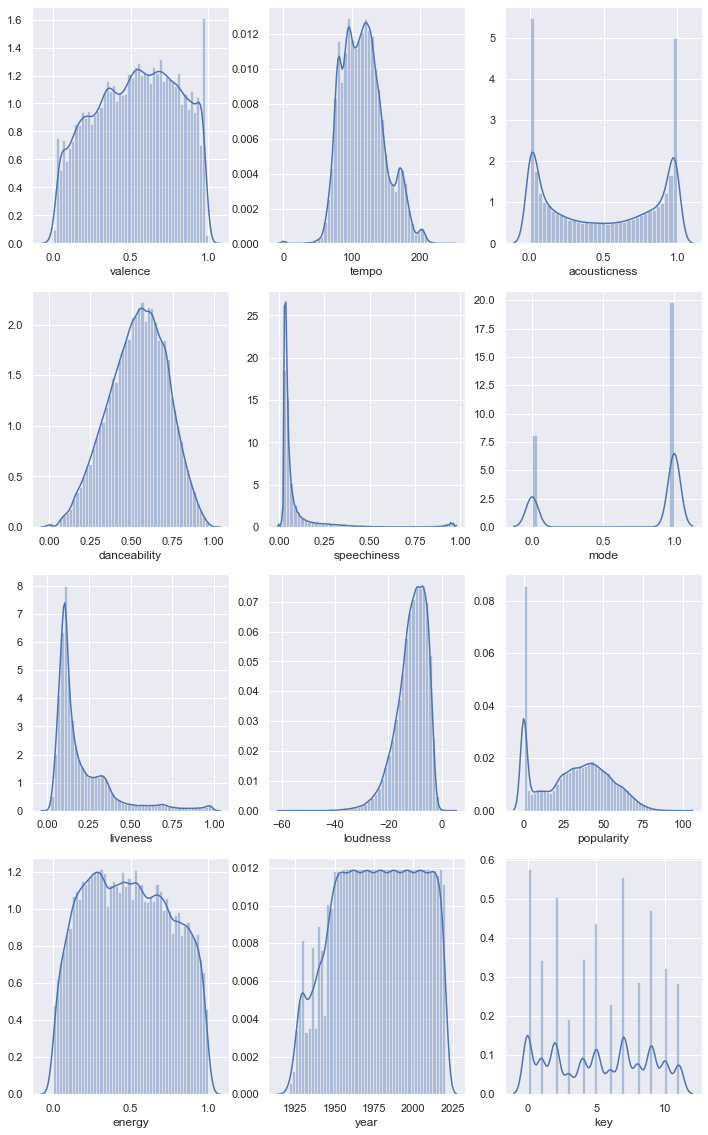

In [98]:
#Visualisation of the distribution of each column
fig,ax = plt.subplots(4,3,figsize=(12,20))
sns.set(font_scale = 1)
sns.distplot(data['valence'],ax=ax[0,0])
sns.distplot(data['tempo'],ax=ax[0,1])
sns.distplot(data['acousticness'],ax=ax[0,2])
sns.distplot(data['danceability'],ax=ax[1,0])
sns.distplot(data['speechiness'],ax=ax[1,1])
sns.distplot(data['mode'],ax=ax[1,2])
sns.distplot(data['liveness'],ax=ax[2,0])
sns.distplot(data['loudness'],ax=ax[2,1])
sns.distplot(data['popularity'],ax=ax[2,2])
sns.distplot(data['energy'],ax=ax[3,0])
sns.distplot(data['year'],ax=ax[3,1])
sns.distplot(data['key'],ax=ax[3,2])

#### Key takeaways:
##### 1. columns such as energy, year and valence has high variability
##### 2. columns such as liveness, danceability, tempo and loudness has relatively lower variablility and concentrated in some ranges.

In [24]:
### lets analyse the correlation between columns
data.corr()

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,duration_min
acousticness,1.000000,-0.263464,-0.749291,-0.253265,0.332575,-0.021993,-0.023591,-0.565272,0.046665,-0.591191,-0.055175,-0.203884,-0.182627,-0.622659,-0.079422
danceability,-0.263464,1.000000,0.217787,0.241560,-0.278995,0.022762,-0.106096,0.291156,-0.045720,0.217835,0.224853,-0.006531,0.558914,0.200236,-0.134653
energy,-0.749291,0.217787,1.000000,0.141939,-0.284113,0.030471,0.126180,0.782250,-0.038493,0.494942,-0.046449,0.249041,0.347789,0.530132,0.036380
explicit,-0.253265,0.241560,0.141939,1.000000,-0.137666,0.008460,0.039306,0.152031,-0.083489,0.213499,0.413097,0.011116,-0.023345,0.244689,-0.044096
instrumentalness,0.332575,-0.278995,-0.284113,-0.137666,1.000000,-0.014397,-0.046907,-0.412768,-0.035220,-0.295619,-0.114935,-0.105676,-0.190712,-0.286838,0.085819
key,-0.021993,0.022762,0.030471,0.008460,-0.014397,1.000000,0.000003,0.022557,-0.113128,0.011022,0.015366,0.003561,0.029411,0.012738,-0.002856
liveness,-0.023591,-0.106096,0.126180,0.039306,-0.046907,0.000003,1.000000,0.052530,0.005492,-0.076040,0.147703,0.007888,-0.000687,-0.056558,0.034749
loudness,-0.565272,0.291156,0.782250,0.152031,-0.412768,0.022557,0.052530,1.000000,-0.013285,0.463395,-0.107780,0.210187,0.305340,0.487084,-0.015799
mode,0.046665,-0.045720,-0.038493,-0.083489,-0.035220,-0.113128,0.005492,-0.013285,1.000000,-0.033175,-0.057641,0.014639,0.014482,-0.033377,-0.047227
popularity,-0.591191,0.217835,0.494942,0.213499,-0.295619,0.011022,-0.076040,0.463395,-0.033175,1.000000,-0.137513,0.133718,0.004857,0.880461,0.063354


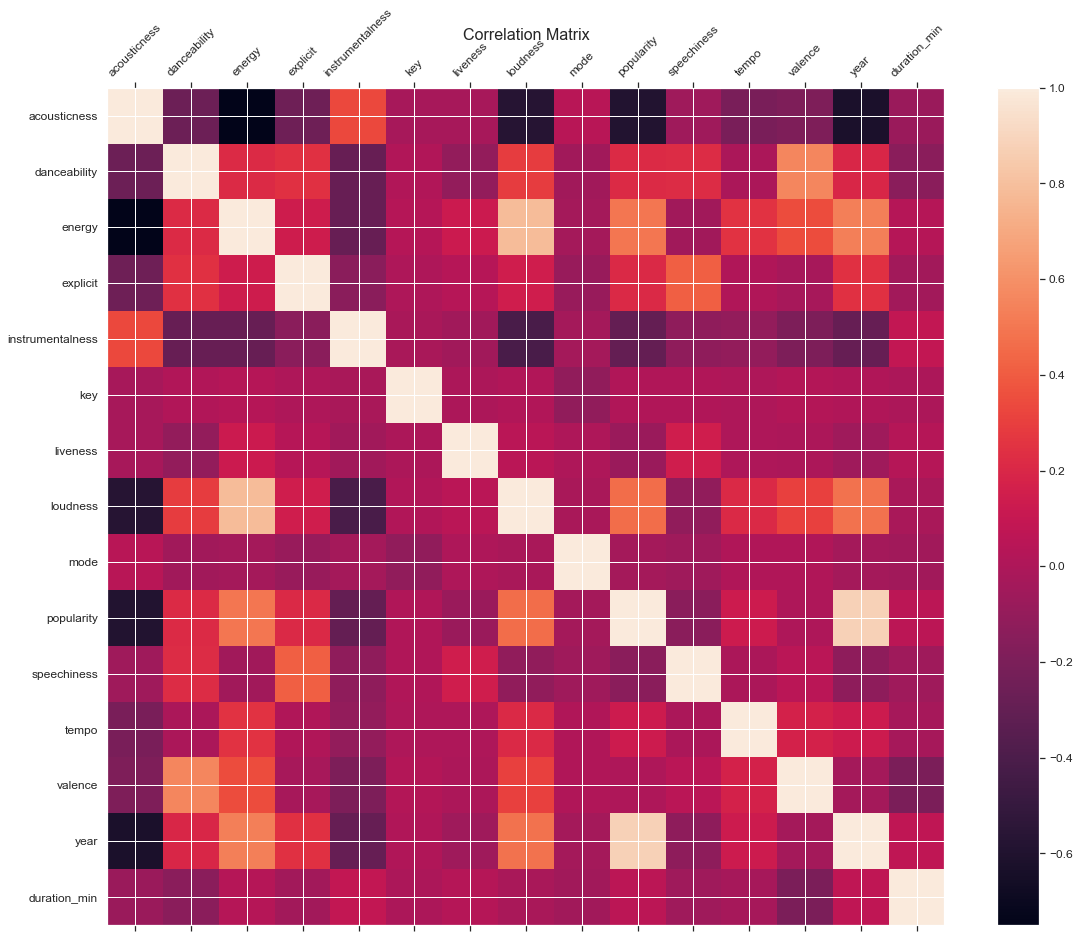

In [100]:
## visualization of the correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12, rotation=45)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize=16);

#### Key takeaways:
##### 1. danceability and valence has high correlation
##### 2. loudness has high correlation with energy
##### 3. accousticness has negative correlation with energy, loudness, popularity and year
##### 4. popularity is highly positively correlated with year. Also loudness and energy seem to have strong correlation with popularity

In [26]:
## In the next cells, we will do further exploration of the dataset to understand it further.

In [27]:
# get top ten tracks (by popularity)
top_ten_tracks = data.groupby("name")['popularity'].mean().sort_values(ascending=False).head(10)
top_ten_tracks.head(10)

name
death bed (coffee for your head) (feat. beabadoobee)    97.0
Supalonely                                              95.0
ily (i love you baby) (feat. Emilee)                    95.0
GOOBA                                                   94.0
Stuck with U (with Justin Bieber)                       94.0
Boss Bitch                                              92.0
SICKO MODE                                              92.0
Breaking Me                                             92.0
ROXANNE                                                 92.0
Savage Remix (feat. Beyoncé)                            92.0
Name: popularity, dtype: float64

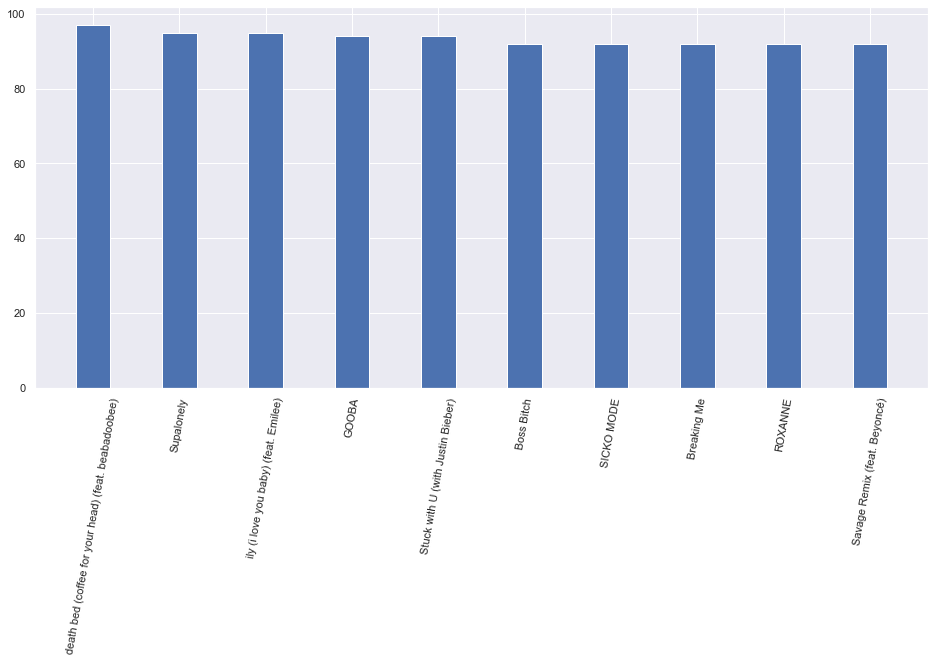

In [33]:
# closer look at the popular tracks
fig, axis = plt.subplots(figsize = (16,7))
axis = plt.bar(top_ten_tracks.index, top_ten_tracks, width=0.4)
plt.xticks(rotation = 80);

In [35]:
# Lets analyse most popular artists, The Beatles are the most popular artists
top_ten_artists = data.groupby("artists")['popularity'].sum().sort_values(ascending=False).head(10)
top_ten_artists.head(10)

artists
The Beatles           19711
The Rolling Stones    17670
Bob Dylan             16628
Elvis Presley         16343
Frank Sinatra         15324
Led Zeppelin          13890
Fleetwood Mac         13844
Queen                 13802
The Beach Boys        13789
Johnny Cash           13095
Name: popularity, dtype: int64

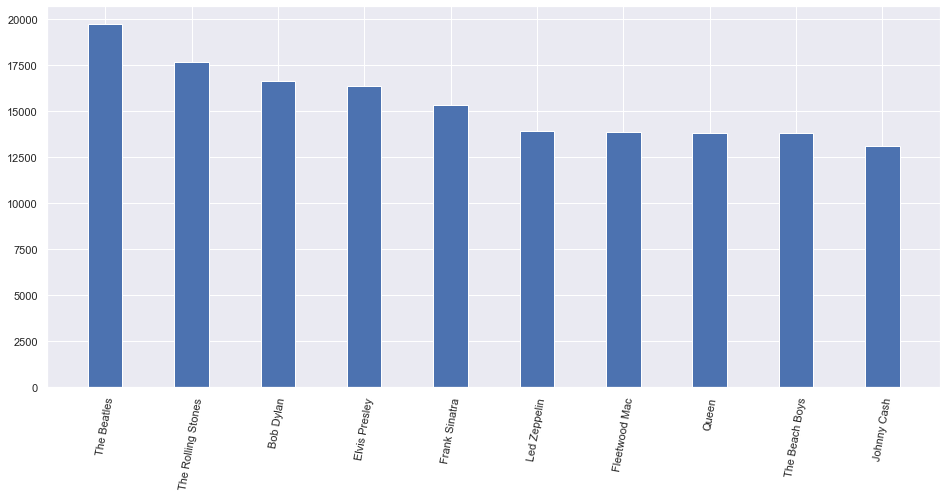

In [36]:
# closer look at popularity
fig, axis = plt.subplots(figsize = (16,7))
axis = plt.bar(top_ten_artists.index, top_ten_artists, width=0.4)
plt.xticks(rotation = 80);

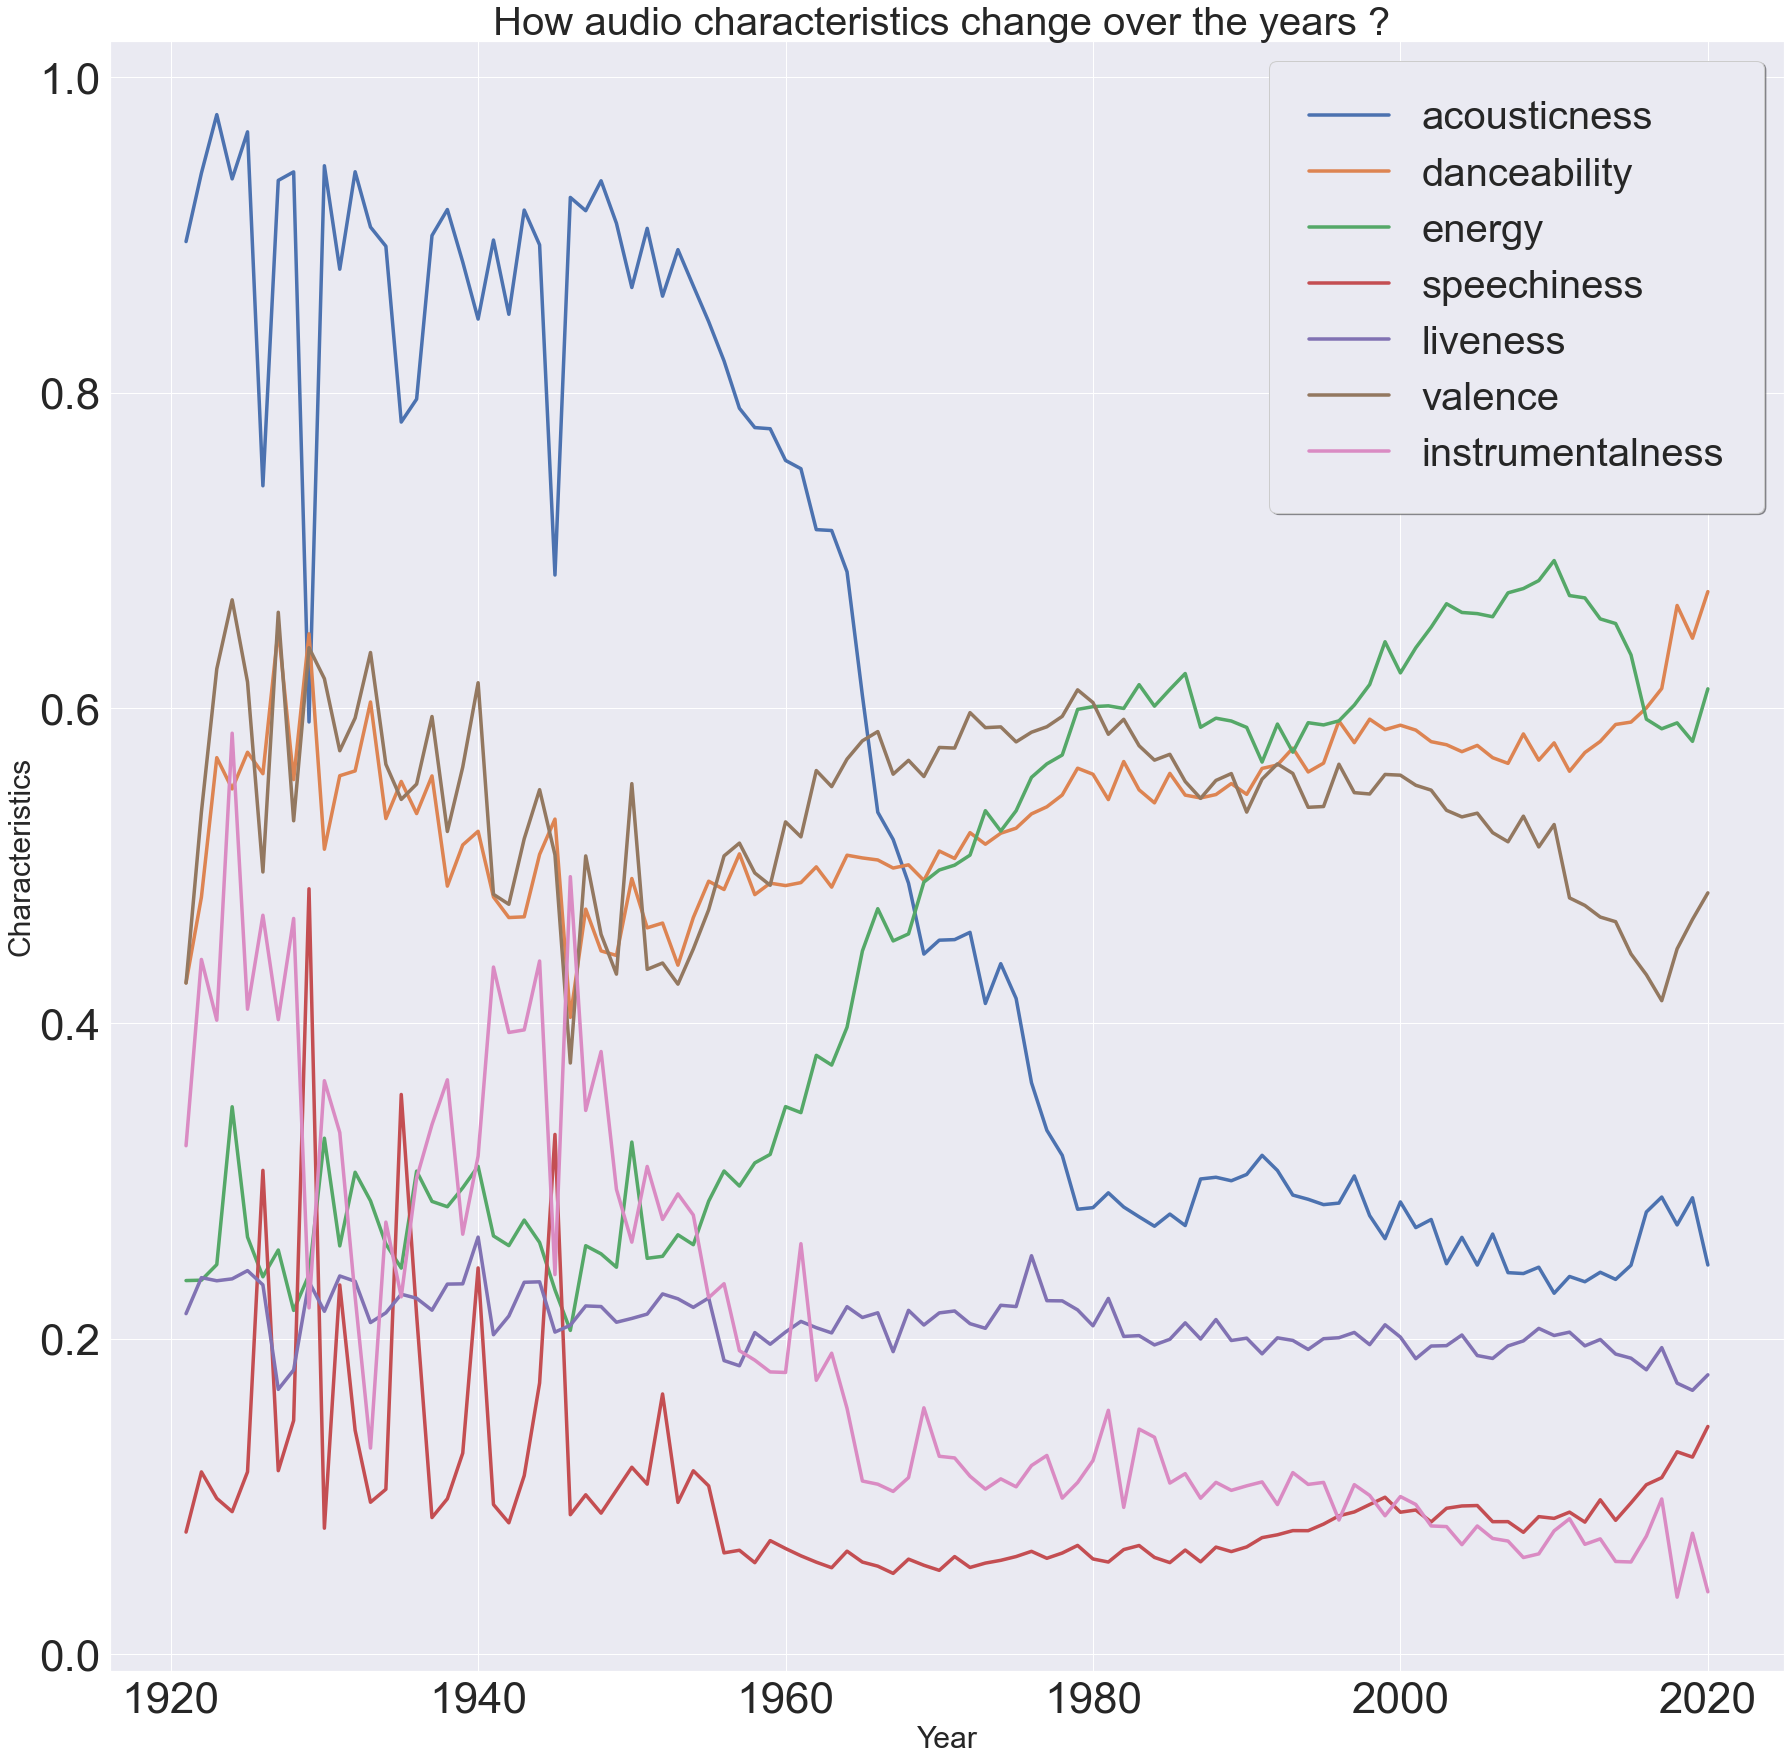

In [38]:
### here we will look at audio characterstics evolution over the years

columns = ["acousticness","danceability","energy","speechiness","liveness","valence", "instrumentalness"]
plt.figure(figsize=(30,30))
sns.set(font_scale=4) 
for c in columns:
    x = data.groupby('year')[c].mean()
    sns.lineplot(x.index,x,linewidth = 3.5,label=c)
plt.title('How audio characteristics change over the years ? ', fontsize=40)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Characteristics',fontsize=30)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 40}, loc = 'upper right')
plt.show()

##### We can see that some characterstics decline over the years, e.g. accousticness, instrumentalness where as others such as energy show an incerase over the years.
##### features such as valence are more or less the same over the years

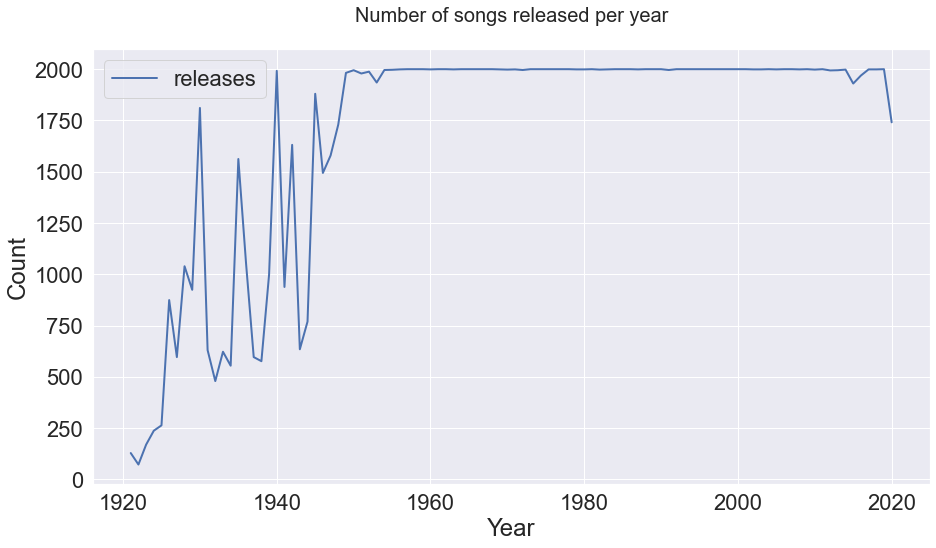

In [39]:
# numbe of song releases per year
number_of_releases = pd.DataFrame(data['year'].value_counts())
number_of_releases.rename({'year': 'releases'}, axis=1, inplace=True)
number_of_releases = number_of_releases.sort_index()
sns.set(font_scale=2) 
ax=number_of_releases.plot(kind='line',figsize=(15,8), linewidth=2)
plt.title("Number of songs released per year",y=1.05,fontsize=20)
plt.xlabel('Year')
plt.ylabel('Count')
ax.axes.get_xaxis().set_visible(True)

##### number of releases seems to be relatively stable starting from 1960, a bit surprising to me, I expected an increase over the years.

### Data Modeling, deployment and Evaluation

In [40]:
### Lets remind ourselves that we want to predict the popularity of a track.

In [41]:
# which features are highly correlated with popularity?
data.corr()['popularity']

acousticness       -0.591191
danceability        0.217835
energy              0.494942
explicit            0.213499
instrumentalness   -0.295619
key                 0.011022
liveness           -0.076040
loudness            0.463395
mode               -0.033175
popularity          1.000000
speechiness        -0.137513
tempo               0.133718
valence             0.004857
year                0.880461
duration_min        0.063354
Name: popularity, dtype: float64

In [42]:
# feature selection based on correlation
#Correlation with the output variable
cor_target = abs(data.corr()["popularity"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target> 0.1]
feature_cols = relevant_features.keys().to_list()
feature_cols

['acousticness',
 'danceability',
 'energy',
 'explicit',
 'instrumentalness',
 'loudness',
 'popularity',
 'speechiness',
 'tempo',
 'year']

In [43]:
## preparing a dataset for training
df = data[feature_cols] # get a dataset with only selected features
df = df[~df.duplicated()==1]
df.head()

,acousticness,danceability,energy,explicit,instrumentalness,loudness,popularity,speechiness,tempo,year
0,0.995,0.708,0.1950,0,0.563,-12.428,0,0.0506,118.469,1928
1,0.994,0.379,0.0135,0,0.901,-28.454,0,0.0462,83.972,1928
2,0.604,0.749,0.2200,0,0.000,-19.924,0,0.9290,107.177,1928
3,0.995,0.781,0.1300,0,0.887,-14.734,0,0.0926,108.003,1928
4,0.990,0.210,0.2040,0,0.908,-16.829,1,0.0424,62.149,1928


In [44]:
#Split the data to train and test using sklearn 
# target column is popularity and we use 80% - 20% split
X_train, X_test, y_train, y_test = train_test_split(df.drop('popularity', axis=1), df['popularity'], test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(135286, 9) (33822, 9) (135286,) (33822,)


In [45]:
# feature transformation
df['tempo'].describe() # it seems that tempo of zero should be replaced, since tempo in (BPM) cannot be zero.

count    169108.000000
mean        117.009016
std          30.713985
min           0.000000
25%          93.607000
50%         114.846000
75%         135.768000
max         244.091000
Name: tempo, dtype: float64

In [47]:
# A function to transform tempo using either median or mean value
def tempoTransformer(X, method):
    '''
    Input: 
    X - dataset
    method - either median or mean
    Output:
    A dataset with zero tempo values transformed by the method.
    '''
    if method == 'median':
        X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].median()
    elif method == 'mean':
        X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].mean()
    else:
        raise Exception("method is either 'median' or 'mean'")
    return X
#Apply Tempo Transformer Train & Test set
X_train = tempoTransformer(X_train, "median")
X_test = tempoTransformer(X_test, "median")

In [48]:
## Apply minmaxscaler to columns in training data that are not in (0,1) range
scaler = MinMaxScaler()
cols = ['loudness','tempo', 'year']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.fit_transform(X_test[cols])

In [49]:
# normalize the target (popularity) to the range of 0 --- 1
y_train = y_train / 100
y_test = y_test / 100

In [50]:
## Lets examine the training set one more time to see the columns are as expected
X_train

,acousticness,danceability,energy,explicit,instrumentalness,loudness,speechiness,tempo,year
107875,0.98900,0.473,0.150,0,0.000213,0.642550,0.0838,0.434413,0.111111
5166,0.09990,0.739,0.758,0,0.000000,0.843661,0.2170,0.308574,0.707071
60276,0.62500,0.294,0.329,0,0.000320,0.742761,0.0338,0.243585,0.696970
146089,0.97300,0.722,0.144,0,0.869000,0.633576,0.0457,0.422360,0.303030
12313,0.24200,0.609,0.347,0,0.000002,0.694668,0.0277,0.306782,0.606061
...,...,...,...,...,...,...,...,...,...
120249,0.55000,0.466,0.264,0,0.000000,0.724141,0.0405,0.608187,0.404040
103960,0.03570,0.619,0.820,0,0.644000,0.791559,0.0352,0.441587,0.666667
132378,0.00207,0.360,0.839,0,0.000115,0.833686,0.0601,0.479814,0.686869
147471,0.74900,0.429,0.347,0,0.000049,0.756573,0.0322,0.432400,0.444444


##### Everything is ready to apply ML.
##### We start with DecisionTree regression, then we will build a RandomForest Model.
##### Finally we compare the tree based methods with a deep learning model.

In [53]:
# A function that fits a decision tree model and returns performance metrics. 
def Dtree(X_train,y_train,X_test,y_test,min_samples_split,max_leaf_nodes, max_depth):
    """
    Initialize a DecisionTree model and returns r2-score and Root Mean squared Errors
    
    INPUT:
    :X_train: 
    :y_train: 
    :X_test: 
    :y_test: 
    :Decision Tree regressor parameters: min_samples_split, max_leaf_nodes and max_depth: 

    OUTPUT:
    training_rmse - RMSE for training dataset
    test_rmse - RMSE for test data
    r2_training - r2-score for training data
    r2_test - r2-score for test data
    y_train_pred and y_test_pred - predictions for training and test data
    mae - Mean Absolute Error
    """
    # initialize a DecisionTree regressor model
    tree = DecisionTreeRegressor(max_leaf_nodes =max_leaf_nodes , min_samples_split =min_samples_split, max_depth = max_depth )
    # fit the model with training data
    tree.fit(X_train, y_train)
    # get the prediction for the training set
    y_train_pred = tree.predict(X_train)
    # calculate rmse between training prediction and ground truth (y_train)
    training_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    # get the prediction for test data
    y_test_pred = tree.predict(X_test)
    # calucate rmse for test prediction
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    # calculate training and test r2 scores
    r2_training = r2_score(y_train, y_train_pred)
    r2_test= r2_score(y_test, y_test_pred)
    # compute mean absolute error
    mae = (abs(y_test - y_test_pred)).mean() 
    return training_rmse,test_rmse,r2_training,r2_test,y_train_pred,y_test_pred,mae

training_rmse, test_rmse, r2_train, r2_test,y_train_pred,y_test_pred,mae= Dtree(X_train,y_train,
                                                                                     X_test,y_test,2, 80, 9)

print("RMSE for training is {}".format(training_rmse))
print("RMSE for test is {}".format(test_rmse))
print("r2-score for training data is {}".format(r2_train))
print("r2-score for test data is {}".format(r2_test))
print("MAE for test data is {}".format(mae))

RMSE for training is 0.09064340132747023
RMSE for test is 0.09199619982999728
r2-score for training data is 0.8230468711586534
r2-score for test data is 0.8159717369830932
MAE for test data is 0.06631601536459332


In [54]:
# grid search CV to get the best parameters for the decision tree model
# initialize number of features and samples
no_features = df.shape[1] - 1
no_samples = df.shape[0]
# define grid parameter list 
grid = GridSearchCV(DecisionTreeRegressor(random_state=1), cv=5, n_jobs=-1, verbose=5,
                    param_grid ={
                    'max_depth': [None,5,7,9,11,15],
                    'max_leaf_nodes': [5,20,40,80,120,160,200],
                    'max_features': ['sqrt', 'auto', 'log2', 0.3,0.5,0.7, no_features//2, no_features//3],
                    'min_samples_split': [2],
                    'min_samples_leaf':[1]},
                    )
 
grid.fit(X_train, y_train)
print('Training r^2 Score : %.3f'%grid.best_estimator_.score(X_train, y_train))
print('Test r^2 Score : %.3f'%grid.best_estimator_.score(X_test,y_test))
print('Best r^2 score by the grid search : %.3f'%grid.best_score_)
print('Best parameters from the grid search : ',grid.best_params_)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:  3.3min finished


Training r^2 Score : 0.825
Test r^2 Score : 0.816
Best r^2 score by the grid search : 0.820
Best parameters from the grid search :  {'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 120, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [58]:
# Decision tree model with tuned hyperparameters using GridSearchCV
dec_tree_tuned = DecisionTreeRegressor(max_depth=9, max_features='auto', 
                                  min_samples_leaf=1, min_samples_split=2, max_leaf_nodes=120, random_state=1)
dec_tree_tuned.fit(X_train,y_train)
y_train_pred = dec_tree_tuned.predict(X_train)
y_test_pred = dec_tree_tuned.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'Mean absolute error of this model: {mae_tuned:.3f}')
print(f'r2 score for training data: {r2_train:.3f}')
print(f'r2 score for test data: {r2_test:.3f}')

Mean absolute error of this model: 0.066
r2 score for training data: 0.825
r2 score for test data: 0.816


In [57]:
### Random forest model
def Randomforest(X_train,y_train,X_test,y_test):
    """
    INPUT:
    X_train 
    y_train 
    X_test: 
    y_test: 
    OUTPUT:
    Mean Absolute Error
    r2-score for training and test
    """
    #initialize a RF model with default parameters
    clf = RandomForestRegressor()
    # fitting the model
    clf.fit(X_train, y_train)
    # predict based on the test data
    preds = clf.predict(X_test)
    # compute mean absolute error
    mae = (abs(y_test - preds)).mean() 
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    # compute r2 scores
    r2_training = r2_score(y_train, y_train_pred)
    r2_test= r2_score(y_test, y_test_pred)
    return mae,r2_train,r2_test

mae,r2_training,r2_test =  Randomforest(X_train,y_train,X_test,y_test)
print("Mean Absolute Error: {:.3f} ".format(mae))
print("r2-score of training is {} and r2 score for test data is {}".format(r2_training, r2_test))

Mean Absolute Error: 0.066 
r2-score of training is 0.8230468711586534 and r2 score for test data is 0.8185133600223405


In [59]:
# grid search CV to search best parameters for RF
no_features = df.shape[1] - 1
no_samples = df.shape[0]
grid = GridSearchCV(RandomForestRegressor(random_state=1), cv=3, n_jobs=-1, verbose=5,
                    param_grid ={
                    'n_estimators':[10, 50, 100, 150, 200],
                    'max_depth': [None,5,7,9,11,15],
                    'max_leaf_nodes': [5,20,40,80,120,160,200],
                    'max_features': ['sqrt', 'auto', 'log2', 0.5, no_features//2, no_features//3],
                    'min_samples_split': [2],
                    'min_samples_leaf':[1]},
                    )
 
grid.fit(X_train, y_train)
print('Training r2 score : %.3f'%grid.best_estimator_.score(X_train, y_train))
print('Test r2 score : %.3f'%grid.best_estimator_.score(X_test,y_test))
print('Best r2 score during r2 score : %.3f'%grid.best_score_)
print('Best parameters for the RF : ',grid.best_params_)

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 42.8min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 68.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 86.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 107.4min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 134.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 158.1min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 192.0min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 225.4min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780

Training r2 score : 0.832
Test r2 score : 0.820
Best r2 score during r2 score : 0.824
Best parameters for the RF :  {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [79]:
# Random forest with tuned hyperparameters from GridSearchCV
rf_tuned = RandomForestRegressor(max_depth=11, max_features='auto', n_estimators=200,
                                  min_samples_leaf=1, min_samples_split=2, max_leaf_nodes=200, random_state=1)
rf_tuned.fit(X_train,y_train)
y_train_pred = rf_tuned.predict(X_train)
y_test_pred = rf_tuned.predict(X_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
training_rmse = (mean_squared_error(y_train, y_train_pred))
test_rmse = (mean_squared_error(y_test, y_test_pred))
mae_tuned = mean_absolute_error(y_test, y_test_pred)
print(f'Mean absolute error of this model: {mae_tuned:.3f}')
print(f'r2 score for training data: {r2_train:.3f}')
print(f'r2 score for test data: {r2_test:.3f}')
print(f'RMSE for training data: {training_rmse:.3f}')
print(f'RMSE for test data: {test_rmse:.3f}')

Mean absolute error of this model: 0.065
r2 score for training data: 0.832
r2 score for test data: 0.820
RMSE for training data: 0.008
RMSE for test data: 0.008


##### The RF model has a slightly better performance than the DecisionTree model that we have build earlier.

In [68]:
### Building a deep learning Model ###
# Setting up the neural network (3 hidden layers with one output layers)
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(9,)))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(16, activation='relu'))
network.add(layers.Dense(1))
#
# Configure the network with optimizer, loss function and metrics
#
network.compile(optimizer=optimizers.Adam(lr=0.0005),
                loss='mse',
                metrics=['mae'])
#
# Fit the network
#
train_history = network.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50)

Train on 135286 samples, validate on 33822 samples
Epoch 1/50
135286/135286 [==============================] - 17s 124us/step - loss: 0.0095 - mean_absolute_error: 0.0715 - val_loss: 0.0088 - val_mean_absolute_error: 0.0675
Epoch 2/50
135286/135286 [==============================] - 15s 111us/step - loss: 0.0088 - mean_absolute_error: 0.0684 - val_loss: 0.0091 - val_mean_absolute_error: 0.0666
Epoch 3/50
135286/135286 [==============================] - 23s 169us/step - loss: 0.0087 - mean_absolute_error: 0.0679 - val_loss: 0.0089 - val_mean_absolute_error: 0.0670
Epoch 4/50
135286/135286 [==============================] - 18s 136us/step - loss: 0.0086 - mean_absolute_error: 0.0674 - val_loss: 0.0086 - val_mean_absolute_error: 0.0664
Epoch 5/50
135286/135286 [==============================] - 16s 120us/step - loss: 0.0086 - mean_absolute_error: 0.0673 - val_loss: 0.0086 - val_mean_absolute_error: 0.0673
Epoch 6/50
135286/135286 [==============================] - 15s 114us/step - loss: 0

Epoch 48/50
135286/135286 [==============================] - 13s 99us/step - loss: 0.0083 - mean_absolute_error: 0.0654 - val_loss: 0.0085 - val_mean_absolute_error: 0.0647
Epoch 49/50
135286/135286 [==============================] - 13s 100us/step - loss: 0.0083 - mean_absolute_error: 0.0654 - val_loss: 0.0084 - val_mean_absolute_error: 0.0663
Epoch 50/50
135286/135286 [==============================] - 18s 132us/step - loss: 0.0083 - mean_absolute_error: 0.0654 - val_loss: 0.0084 - val_mean_absolute_error: 0.0661


In [73]:
### Building a deep learning Model ###
# Setting up the neural network (3 hidden layers with one output layers)
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(9,)))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
#network.add(layers.Dense(16, activation='relu'))
network.add(layers.Dense(1))
#
# Configure the network with optimizer, loss function and metrics
#
network.compile(optimizer=optimizers.Adam(lr=0.0001),
                loss='mse',
                metrics=['mae'])
#
# Fit the network
#
train_history = network.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=500)

Train on 135286 samples, validate on 33822 samples
Epoch 1/500
135286/135286 [==============================] - 11s 80us/step - loss: 0.0098 - mean_absolute_error: 0.0740 - val_loss: 0.0091 - val_mean_absolute_error: 0.0704
Epoch 2/500
135286/135286 [==============================] - 9s 67us/step - loss: 0.0090 - mean_absolute_error: 0.0699 - val_loss: 0.0090 - val_mean_absolute_error: 0.0691
Epoch 3/500
135286/135286 [==============================] - 9s 64us/step - loss: 0.0088 - mean_absolute_error: 0.0690 - val_loss: 0.0089 - val_mean_absolute_error: 0.0700
Epoch 4/500
135286/135286 [==============================] - 8s 61us/step - loss: 0.0088 - mean_absolute_error: 0.0685 - val_loss: 0.0088 - val_mean_absolute_error: 0.0676
Epoch 5/500
135286/135286 [==============================] - 9s 66us/step - loss: 0.0087 - mean_absolute_error: 0.0681 - val_loss: 0.0087 - val_mean_absolute_error: 0.0677
Epoch 6/500
135286/135286 [==============================] - 10s 75us/step - loss: 0.008

135286/135286 [==============================] - 9s 67us/step - loss: 0.0083 - mean_absolute_error: 0.0656 - val_loss: 0.0084 - val_mean_absolute_error: 0.0654
Epoch 49/500
135286/135286 [==============================] - 9s 67us/step - loss: 0.0083 - mean_absolute_error: 0.0656 - val_loss: 0.0084 - val_mean_absolute_error: 0.0669
Epoch 50/500
135286/135286 [==============================] - 9s 67us/step - loss: 0.0083 - mean_absolute_error: 0.0656 - val_loss: 0.0084 - val_mean_absolute_error: 0.0655
Epoch 51/500
135286/135286 [==============================] - 8s 63us/step - loss: 0.0083 - mean_absolute_error: 0.0655 - val_loss: 0.0084 - val_mean_absolute_error: 0.0662
Epoch 52/500
135286/135286 [==============================] - 9s 68us/step - loss: 0.0083 - mean_absolute_error: 0.0656 - val_loss: 0.0085 - val_mean_absolute_error: 0.0665
Epoch 53/500
135286/135286 [==============================] - 9s 66us/step - loss: 0.0083 - mean_absolute_error: 0.0656 - val_loss: 0.0084 - val_mea

135286/135286 [==============================] - 9s 69us/step - loss: 0.0081 - mean_absolute_error: 0.0649 - val_loss: 0.0083 - val_mean_absolute_error: 0.0651
Epoch 143/500
135286/135286 [==============================] - 9s 66us/step - loss: 0.0081 - mean_absolute_error: 0.0649 - val_loss: 0.0084 - val_mean_absolute_error: 0.0652
Epoch 144/500
135286/135286 [==============================] - 9s 68us/step - loss: 0.0081 - mean_absolute_error: 0.0649 - val_loss: 0.0084 - val_mean_absolute_error: 0.0656
Epoch 145/500
135286/135286 [==============================] - 9s 66us/step - loss: 0.0081 - mean_absolute_error: 0.0649 - val_loss: 0.0084 - val_mean_absolute_error: 0.0656
Epoch 146/500
135286/135286 [==============================] - 9s 63us/step - loss: 0.0081 - mean_absolute_error: 0.0649 - val_loss: 0.0084 - val_mean_absolute_error: 0.0650
Epoch 147/500
135286/135286 [==============================] - 9s 68us/step - loss: 0.0081 - mean_absolute_error: 0.0649 - val_loss: 0.0084 - va

135286/135286 [==============================] - 8s 63us/step - loss: 0.0080 - mean_absolute_error: 0.0645 - val_loss: 0.0084 - val_mean_absolute_error: 0.0665
Epoch 237/500
135286/135286 [==============================] - 13s 94us/step - loss: 0.0080 - mean_absolute_error: 0.0645 - val_loss: 0.0085 - val_mean_absolute_error: 0.0643
Epoch 238/500
135286/135286 [==============================] - 9s 66us/step - loss: 0.0080 - mean_absolute_error: 0.0645 - val_loss: 0.0084 - val_mean_absolute_error: 0.0664
Epoch 239/500
135286/135286 [==============================] - 14s 101us/step - loss: 0.0080 - mean_absolute_error: 0.0645 - val_loss: 0.0084 - val_mean_absolute_error: 0.0648
Epoch 240/500
135286/135286 [==============================] - 15s 111us/step - loss: 0.0080 - mean_absolute_error: 0.0645 - val_loss: 0.0084 - val_mean_absolute_error: 0.0651
Epoch 241/500
135286/135286 [==============================] - 11s 82us/step - loss: 0.0080 - mean_absolute_error: 0.0644 - val_loss: 0.008

135286/135286 [==============================] - 9s 66us/step - loss: 0.0080 - mean_absolute_error: 0.0643 - val_loss: 0.0084 - val_mean_absolute_error: 0.0656
Epoch 284/500
135286/135286 [==============================] - 12s 90us/step - loss: 0.0080 - mean_absolute_error: 0.0643 - val_loss: 0.0084 - val_mean_absolute_error: 0.0648
Epoch 285/500
135286/135286 [==============================] - 10s 72us/step - loss: 0.0080 - mean_absolute_error: 0.0643 - val_loss: 0.0084 - val_mean_absolute_error: 0.0666
Epoch 286/500
135286/135286 [==============================] - 12s 87us/step - loss: 0.0080 - mean_absolute_error: 0.0643 - val_loss: 0.0084 - val_mean_absolute_error: 0.0658
Epoch 287/500
135286/135286 [==============================] - 11s 79us/step - loss: 0.0080 - mean_absolute_error: 0.0644 - val_loss: 0.0084 - val_mean_absolute_error: 0.0649
Epoch 288/500
135286/135286 [==============================] - 10s 74us/step - loss: 0.0080 - mean_absolute_error: 0.0643 - val_loss: 0.0085

135286/135286 [==============================] - 9s 64us/step - loss: 0.0080 - mean_absolute_error: 0.0642 - val_loss: 0.0084 - val_mean_absolute_error: 0.0664
Epoch 331/500
135286/135286 [==============================] - 10s 72us/step - loss: 0.0080 - mean_absolute_error: 0.0642 - val_loss: 0.0084 - val_mean_absolute_error: 0.0670
Epoch 332/500
135286/135286 [==============================] - 9s 64us/step - loss: 0.0080 - mean_absolute_error: 0.0642 - val_loss: 0.0084 - val_mean_absolute_error: 0.0657
Epoch 333/500
135286/135286 [==============================] - 9s 65us/step - loss: 0.0080 - mean_absolute_error: 0.0642 - val_loss: 0.0084 - val_mean_absolute_error: 0.0656
Epoch 334/500
135286/135286 [==============================] - 10s 72us/step - loss: 0.0080 - mean_absolute_error: 0.0642 - val_loss: 0.0085 - val_mean_absolute_error: 0.0676
Epoch 335/500
135286/135286 [==============================] - 9s 67us/step - loss: 0.0080 - mean_absolute_error: 0.0642 - val_loss: 0.0084 - 

135286/135286 [==============================] - 9s 64us/step - loss: 0.0079 - mean_absolute_error: 0.0640 - val_loss: 0.0085 - val_mean_absolute_error: 0.0655
Epoch 378/500
135286/135286 [==============================] - 9s 67us/step - loss: 0.0079 - mean_absolute_error: 0.0641 - val_loss: 0.0084 - val_mean_absolute_error: 0.0654
Epoch 379/500
135286/135286 [==============================] - 9s 67us/step - loss: 0.0079 - mean_absolute_error: 0.0640 - val_loss: 0.0084 - val_mean_absolute_error: 0.0656
Epoch 380/500
135286/135286 [==============================] - 9s 63us/step - loss: 0.0079 - mean_absolute_error: 0.0641 - val_loss: 0.0084 - val_mean_absolute_error: 0.0664
Epoch 381/500
135286/135286 [==============================] - 9s 68us/step - loss: 0.0079 - mean_absolute_error: 0.0640 - val_loss: 0.0084 - val_mean_absolute_error: 0.0654
Epoch 382/500
135286/135286 [==============================] - 11s 83us/step - loss: 0.0079 - mean_absolute_error: 0.0640 - val_loss: 0.0084 - v

135286/135286 [==============================] - 9s 67us/step - loss: 0.0079 - mean_absolute_error: 0.0640 - val_loss: 0.0085 - val_mean_absolute_error: 0.0662
Epoch 425/500
135286/135286 [==============================] - 9s 65us/step - loss: 0.0079 - mean_absolute_error: 0.0639 - val_loss: 0.0084 - val_mean_absolute_error: 0.0656
Epoch 426/500
135286/135286 [==============================] - 9s 67us/step - loss: 0.0079 - mean_absolute_error: 0.0639 - val_loss: 0.0085 - val_mean_absolute_error: 0.0660
Epoch 427/500
135286/135286 [==============================] - 10s 72us/step - loss: 0.0079 - mean_absolute_error: 0.0639 - val_loss: 0.0085 - val_mean_absolute_error: 0.0651
Epoch 428/500
135286/135286 [==============================] - 14s 101us/step - loss: 0.0079 - mean_absolute_error: 0.0639 - val_loss: 0.0085 - val_mean_absolute_error: 0.0667
Epoch 429/500
135286/135286 [==============================] - 9s 67us/step - loss: 0.0079 - mean_absolute_error: 0.0639 - val_loss: 0.0084 -

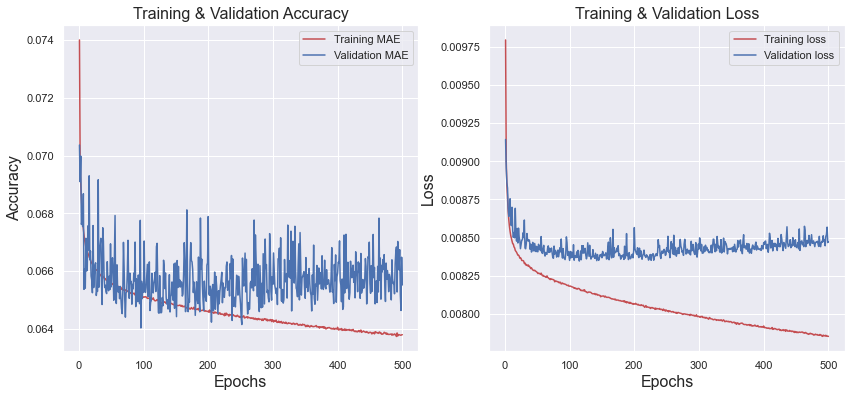

In [75]:
import matplotlib.pyplot as plt
 
history_dict = train_history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['mean_absolute_error']
val_accuracy = history_dict['val_mean_absolute_error']
sns.set(font_scale=1) 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy (MAE) vs Epochs
#
ax[0].plot(epochs, accuracy, 'r-', label='Training MAE')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation MAE')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r-', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

#### Conclusions:
##### We can observe that the deep learning model performance is very close to RF model performance. 
##### Also the deep learning model shows no / only minor improvement (interms of validation data) after about 100 epochs. 
##### In this particular problem, the RF model can be the better option since it is computationaly less expensive and less prone to overfitting than the deep learing approach.